# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model



import numpy as np
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)

#YOU DEFINED OPENNING GAPS AS TODAY'S OPEN TO YESTERDAY'S CLOSE INSTEAD OF TODAY'S OPEN TO YESTERDAY'S HIGH/LOW..

data['opening_gaps_2'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_14']).astype(int)


In [6]:
# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan



# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)

print(data[['Date', 'Open', 'High', 'Low', 'Close/Last', 'opening_gaps_2']])


           Date    Open     High     Low  Close/Last  opening_gaps_2
2515 2014-09-15  199.16  199.320  198.38     198.981             NaN
2514 2014-09-16  198.61  200.840  198.50     200.480             NaN
2513 2014-09-17  200.77  201.680  199.75     200.750             NaN
2512 2014-09-18  201.36  201.850  201.10     201.820             NaN
2511 2014-09-19  201.52  201.899  200.29     200.700             NaN
...         ...     ...      ...     ...         ...             ...
4    2024-09-06  549.94  551.600  539.44     540.360             NaN
3    2024-09-09  544.65  547.710  542.68     546.410             NaN
2    2024-09-10  548.36  549.150  543.38     548.790        0.001185
1    2024-09-11  548.70  555.360  539.96     554.420             NaN
0    2024-09-12  555.01  559.400  552.74     559.090             NaN

[2516 rows x 6 columns]


## <a id="section2"></a> Moving Averages: Today's Price Change

Optimization terminated successfully.
         Current function value: 0.675850
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             day_change   No. Observations:                 2515
Model:                          Logit   Df Residuals:                     2513
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                 0.01988
Time:                        15:28:13   Log-Likelihood:                -1699.8
converged:                       True   LL-Null:                       -1734.2
Covariance Type:            nonrobust   LLR p-value:                 1.012e-16
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2297      0.063     -3.650      0.000      -0.353      -0.106
open_above_MA_

/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_5963/512268460.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)
/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_5963/512268460.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['day_change_label'] = clean_data['day_change'].apply(lambda x: 'Up' if x == 1 else 'Down')
/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_5963/51226

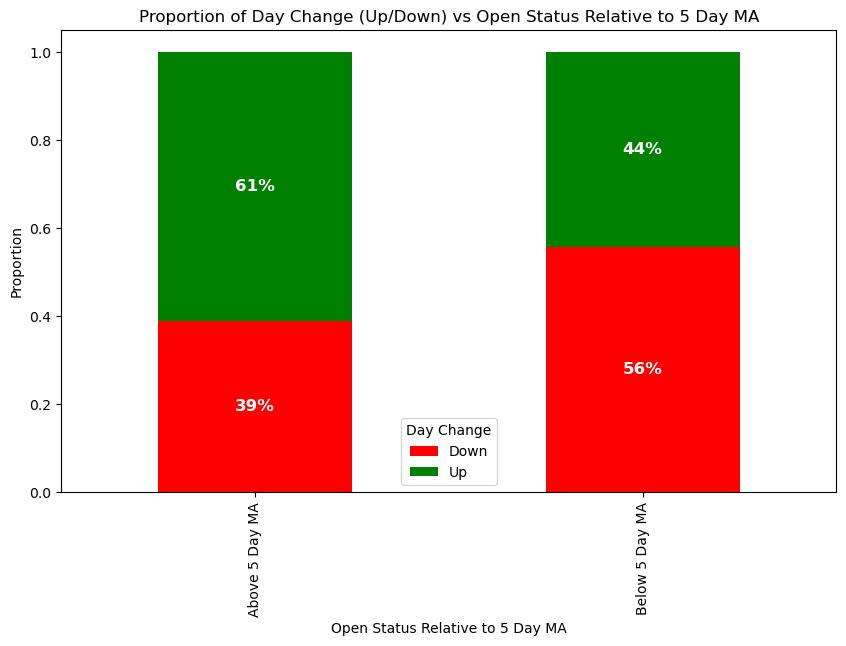

In [38]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'day_change'])

# Logistic regression preparation: Convert 'day_change' to binary (0 for Down, 1 for Up)
clean_data['day_change'] = clean_data['day_change'].apply(lambda x: 1 if x > 0 else 0)

# Create a new column to replace 0 and 1 in 'day_change' with descriptive labels for visualization
clean_data['day_change_label'] = clean_data['day_change'].apply(lambda x: 'Up' if x == 1 else 'Down')

# Create a new column to replace 0 and 1 in 'open_above_MA_5' with descriptive labels
clean_data['open_above_MA_5_label'] = clean_data['open_above_MA_5'].apply(lambda x: 'Above 5 Day MA' if x == 1 else 'Below 5 Day MA')

# Independent variable (open_above_MA_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant to the model (intercept term)
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Print the logistic regression results, including confidence intervals
print(result.summary())

# Extract confidence intervals and rename columns for clarity
conf = result.conf_int()
conf.columns = ['Lower Bound for 95% Interval', 'Upper Bound for 95% Interval']
conf['Odds Ratio'] = result.params
print(conf)

# Count the occurrences of each combination of 'open_above_MA_5_label' and 'day_change_label'
counts = clean_data.groupby(['open_above_MA_5_label', 'day_change_label']).size().unstack().fillna(0)

# Normalize the counts to get proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# Create the stacked bar chart
ax = proportions.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

# Add percentages on top of the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Open Status Relative to 5 Day MA')
plt.ylabel('Proportion')
plt.title('Proportion of Day Change (Up/Down) vs Open Status Relative to 5 Day MA')

# Add legend
plt.legend(title='Day Change')

# Show the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     67.49
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           3.35e-16
Time:                        15:24:30   Log-Likelihood:                 7769.0
No. Observations:                2515   AIC:                        -1.553e+04
Df Residuals:                    2513   BIC:                        -1.552e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0017      0.000     

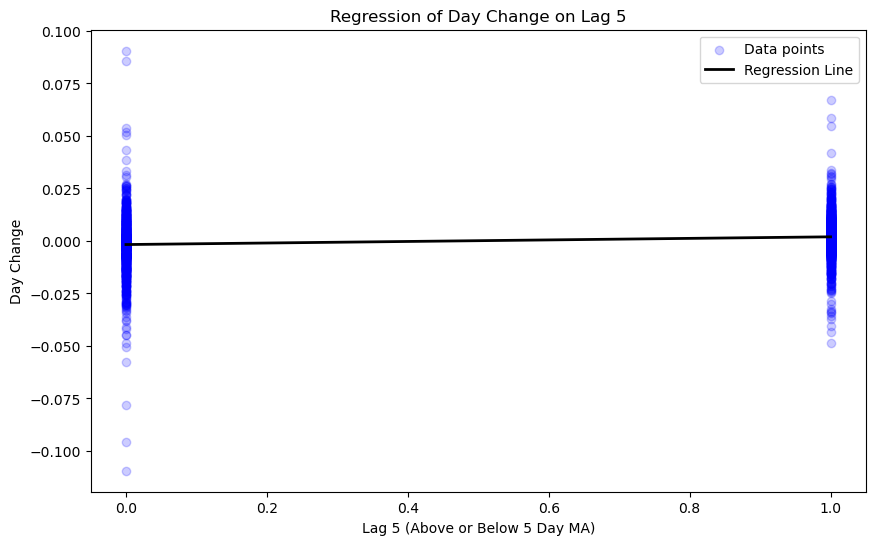

In [37]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 5')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     29.88
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           5.06e-08
Time:                        14:50:56   Log-Likelihood:                 7750.5
No. Observations:                2515   AIC:                        -1.550e+04
Df Residuals:                    2513   BIC:                        -1.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0012      0.000  

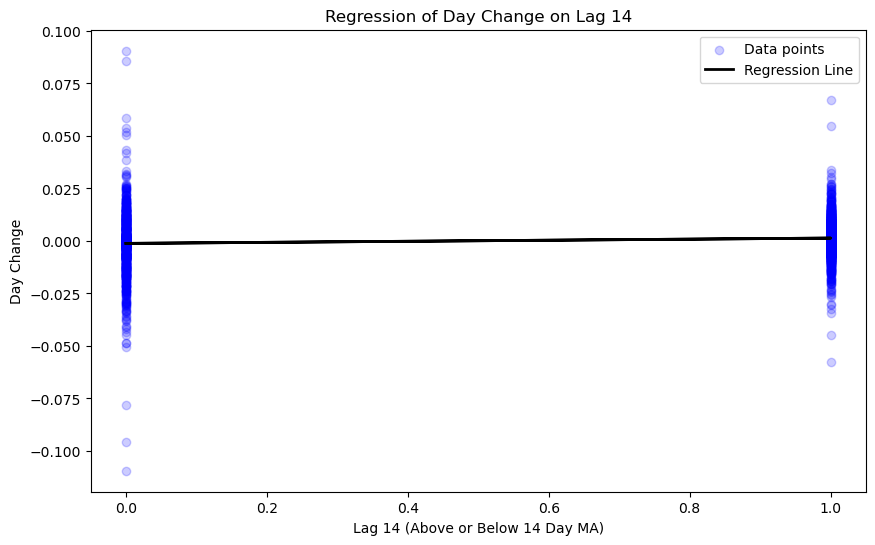

In [8]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_14', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_14']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_14'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_14'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 14 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 14')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.614
Date:                Sat, 14 Dec 2024   Prob (F-statistic):             0.0574
Time:                        14:50:56   Log-Likelihood:                 7737.5
No. Observations:                2515   AIC:                        -1.547e+04
Df Residuals:                    2513   BIC:                        -1.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0002      0.000  

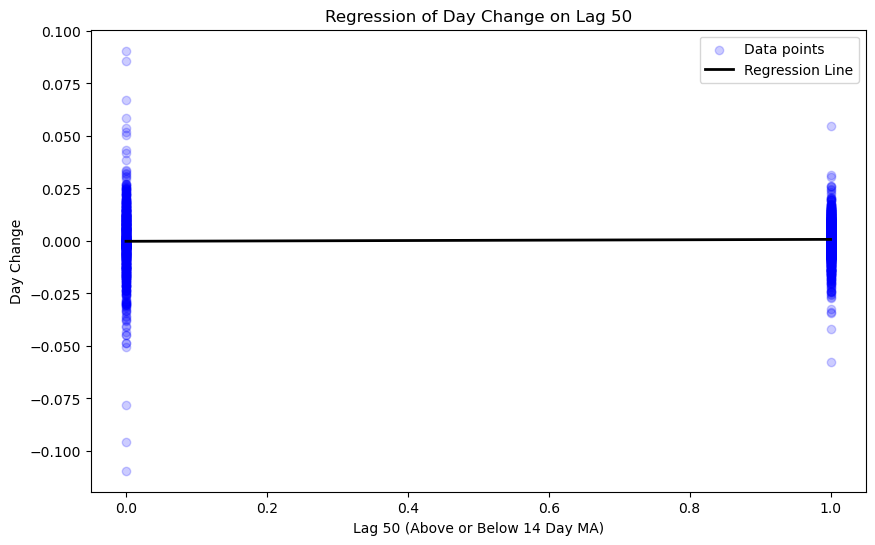

In [9]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_50', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_50'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['open_above_MA_50'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 50 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 50')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [10]:
print('''
all 3 regressions indicate MA are immaterial as predictor or day price change
''')


all 3 regressions indicate MA are immaterial as predictor or day price change



                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     23.09
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           9.60e-15
Time:                        14:50:56   Log-Likelihood:                 7769.9
No. Observations:                2515   AIC:                        -1.553e+04
Df Residuals:                    2511   BIC:                        -1.551e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0017      0.000  

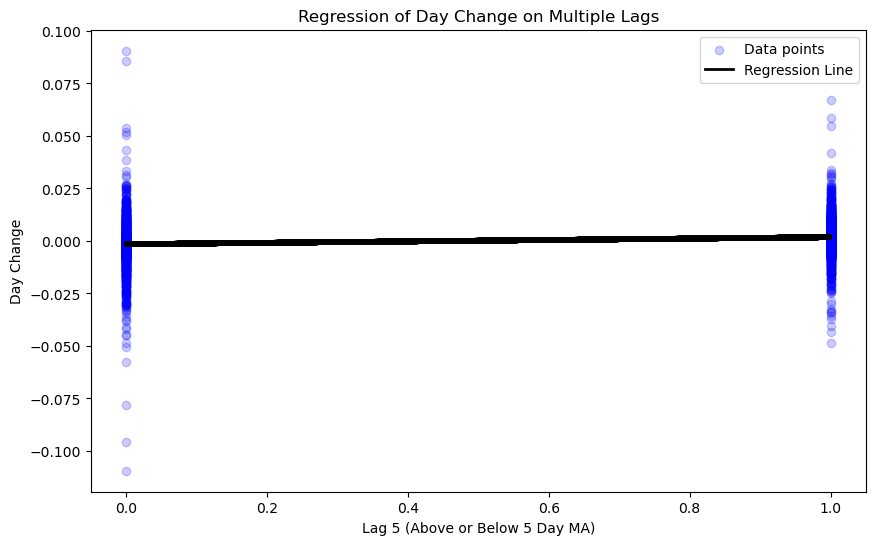

In [11]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables and dependent variable
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot for one of the variables (lag_5 as an example)
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['open_above_MA_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line for one variable (lag_5)
plt.plot(clean_data['open_above_MA_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Multiple Lags')

# Add legend
plt.legend()

# Show and save the plot
plt.savefig('regression_day_change_on_multiple_lags.png', dpi=300)
plt.show()


In [12]:
print('''

Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and open_above_MA_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.

''')



Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and open_above_MA_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.




In [13]:

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50', 'day_change'])

# Independent variables
X = clean_data[['open_above_MA_5', 'open_above_MA_14', 'open_above_MA_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


            feature       VIF
0             const  4.024110
1   open_above_MA_5  1.472361
2  open_above_MA_14  1.820981
3  open_above_MA_50  1.334948


In [14]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?

''')



Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?




                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.004385
Date:                Sat, 14 Dec 2024   Prob (F-statistic):              0.947
Time:                        14:50:57   Log-Likelihood:                 7578.4
No. Observations:                2467   AIC:                        -1.515e+04
Df Residuals:                    2465   BIC:                        -1.514e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

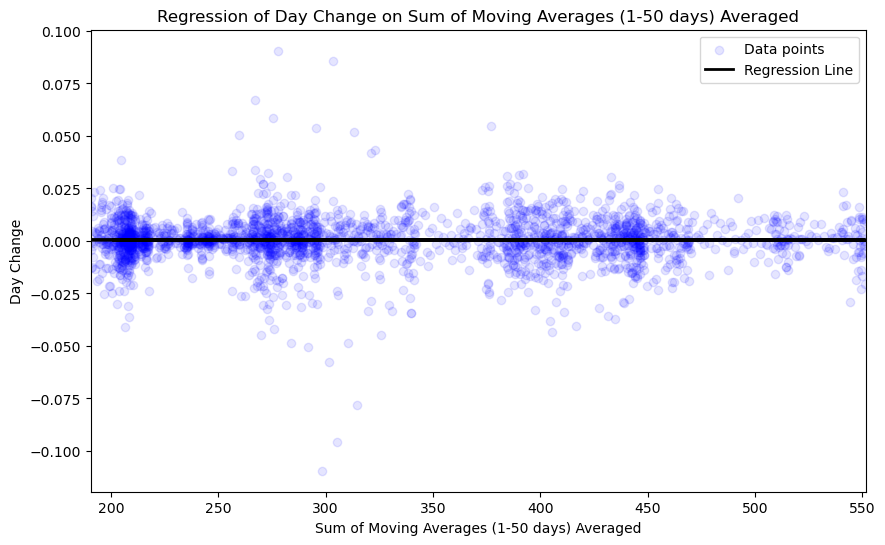



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




In [15]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')


In [16]:
# Create moving average features
for i in range(1, 51):
    data[f'MA_{i}'] = data['Close/Last'].rolling(window=i).mean()

# Drop NaN values
clean_data = data.dropna()

# Initialize a list to store the results
results = []

# Define the train-test split index based on TIME- THIS KEEPS DATA IN CHRONOLOGICAL ORDER
train_size = int(0.8 * len(clean_data))
train, test = clean_data.iloc[:train_size], clean_data.iloc[train_size:]

# Loop through each moving average period
for i in range(1, 51):
    X_train = train[[f'MA_{i}']]
    y_train = train['day_change']
    X_test = test[[f'MA_{i}']]
    y_test = test['day_change']
    
    # Add a constant term for the intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # Fit the OLS model
    ols_model = sm.OLS(y_train, X_train_const).fit()
    
    # Predict and calculate R²
    y_pred = ols_model.predict(X_test_const)
    r2 = r2_score(y_test, y_pred)
    
    # Extract the coefficient, t-value, and p-value for the moving average term (ignoring the intercept)
    coef = ols_model.params[1]
    t_value = ols_model.tvalues[1]
    p_value = ols_model.pvalues[1]
    
    # Store the results
    results.append({'Moving Average': i, 'Coefficient': coef, 'T-Value': t_value, 'P-Value': p_value, 'R²': r2})

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Sort the results by P-Value in ascending order
sorted_results_df = results_df.sort_values(by='P-Value', ascending=True)

# Display the sorted results
print(sorted_results_df)


print('''
looks like there might be more exploring with the moving average 1 day out

If each moving average is not statistically significant on its own it is unlikely that any combinations would be both
significant and not spurious.

testing combinations will be quite difficult because of the multicollinearity, even PCA didn't help, nor will lasso.


''')


    Moving Average   Coefficient   T-Value   P-Value        R²
0                1  8.214843e-06  1.396424  0.162957 -0.022022
1                2  4.062839e-06  0.689300  0.490825 -0.009616
2                3  2.470329e-06  0.418741  0.675513 -0.005940
3                4  1.583965e-06  0.268271  0.788557 -0.004045
23              24 -1.534687e-06 -0.258148  0.796356  0.000715
24              25 -1.533580e-06 -0.257876  0.796566  0.000704
22              23 -1.529280e-06 -0.257310  0.797003  0.000717
25              26 -1.527991e-06 -0.256863  0.797348  0.000685
26              27 -1.527965e-06 -0.256798  0.797398  0.000668
27              28 -1.507865e-06 -0.253365  0.800048  0.000634
21              22 -1.484686e-06 -0.249871  0.802749  0.000677
28              29 -1.486157e-06 -0.249644  0.802924  0.000602
29              30 -1.467853e-06 -0.246488  0.805365  0.000576
30              31 -1.447283e-06 -0.242954  0.808100  0.000552
20              21 -1.436741e-06 -0.241856  0.808951  0

In [17]:
# Assuming 'data' is your DataFrame and 'Close/Last' is your target column

# Create moving average features
for i in range(1, 51):
    data[f'MA_{i}'] = data['Close/Last'].rolling(window=i).mean()

# Drop NaN values
clean_data = data.dropna()

# Initialize a list to store the results
results = []

# Define the train-test split index based on TIME (THIS KEEPS DATA IN CHRONOLOGICAL ORDER)
train_size = int(0.8 * len(clean_data))
train, test = clean_data.iloc[:train_size], clean_data.iloc[train_size:]

# Loop through each moving average period
for i in range(1, 51):
    # Define the feature (moving average) and the target (day_change)
    X_train = train[[f'MA_{i}']]
    y_train = train['day_change']
    X_test = test[[f'MA_{i}']]
    y_test = test['day_change']
    
    # Add a constant term for the intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)
    
    # Fit the OLS model
    ols_model = sm.OLS(y_train, X_train_const).fit()
    
    # Obtain the residuals
    residuals = ols_model.resid
    
    # Rescale the residuals to improve optimizer convergence
    residuals_scaled = residuals * 100
    
    # Fit the GARCH model using the scaled residuals
    garch_model = arch_model(residuals_scaled, vol='Garch', p=1, q=1, reindex=True).fit(disp='off')
    
    # Predict future volatility (for demonstration purposes)
    predictions = garch_model.forecast(horizon=len(X_test), reindex=True)
    predicted_variance = predictions.variance.values[-1, :]
    
    # Calculate error metrics (using the residual variance as a placeholder)
    mse = mean_squared_error(y_test, predicted_variance)
    r2 = r2_score(y_test, predicted_variance)
    
    # Extract model parameters
    params = garch_model.params
    
    # Store the results
    results.append({
        'Moving Average': i,
        'Mean Squared Error': mse,
        'R²': r2,
        'Parameters': params
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Sort the results by R² in descending order
sorted_results_df = results_df.sort_values(by='R²', ascending=False)

# Display the sorted results
print(sorted_results_df)

# Example plotting the first moving average results
ma_example = 1
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['day_change'], label='Actual Returns')
plt.plot(test.index, predicted_variance, label=f'Predicted Variance MA_{ma_example}', color='red')
plt.legend(loc='best')
plt.show()

print('''
By rescaling the residuals and explicitly setting the reindex parameter, the optimizer in the GARCH model should now converge more easily, providing more accurate and reliable parameter estimates and variance predictions.
''')


TypeError: arch_model() got an unexpected keyword argument 'reindex'